[link text](https:// [link text](https://))# Building a Simple Web Agent

## Setup and Dependencies

* **Import necessary libraries:** The code imports libraries for:
Asynchronous operations (asyncio)
Web scraping (playwright)
Data handling (pandas, json)
Image processing (PIL)
Interacting with OpenAI's API (openai)
Displaying results (IPython.display)
* **Environment Variables:** Securely stores the OpenAI API key using google.colab.userdata.
* **Helper Functions:** Defines functions like get_openai_api_key and visualizeCourses for managing API keys and displaying results.

In [12]:
!pip install playwright
!pip install python-dotenv
!pip install multion
!playwright install

Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libavif.so.13                                    ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.11/dist-packages/playwright/driver/package/lib/server/registry/dependencies.js:216:9)
    at process.processTicksAndRejections (node:internal/process/task_queues:105

In [13]:
import asyncio
import json
import os
import nest_asyncio
import pprint
import base64
from io import BytesIO
import pandas as pd
from playwright.async_api import async_playwright
from openai import OpenAI
from PIL import Image
from tabulate import tabulate
from IPython.display import display, HTML, Markdown
from pydantic import BaseModel
#from helper import get_openai_api_key, visualizeCourses # This line is removed
import google.colab
from google.colab import userdata
import os
import openai


In [15]:
## Get the API key from Co-lab Secrets
api_key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = api_key
print(f"API Key preview: {os.environ.get('OPENAI_API_KEY')[:5]}...")

# Initialize the OpenAI client
client = OpenAI(api_key=api_key)

API Key preview: sk-8k...


This code demonstrates a basic web scraping agent using Playwright and OpenAI's GPT model to extract structured data from websites. Here are some potential next steps to improve or extend its functionality:

1.  **Enhance Error Handling:** Implement more robust error handling to gracefully handle potential issues during web scraping or API interactions. Consider using `try-except` blocks to catch exceptions and provide informative error messages.
2.  **Improve Data Extraction:** Refine the instructions provided to the OpenAI API to improve the accuracy and completeness of data extraction. Experiment with different prompts and model parameters to optimize results.
3.  **Add Data Validation:** Include data validation steps to ensure the extracted data conforms to the expected format and data types. This can help prevent errors and inconsistencies in downstream processing.
4.  **Explore Advanced Techniques:** Consider incorporating advanced web scraping techniques, such as handling dynamic content with JavaScript rendering, using proxies for IP rotation, and implementing strategies to avoid detection.
5.  **Integrate with Data Pipelines:** Connect the web scraping agent to a data pipeline for automated data extraction, transformation, and loading (ETL) processes. This can facilitate data analysis and visualization workflows.
6.  **Develop a User Interface:** Create a user-friendly interface to allow users to specify target URLs, instructions, and data extraction parameters without needing to modify the code directly.
7.  **Deploy to a Production Environment:** If intended for production use, deploy the web scraping agent to a scalable and reliable environment, such as a cloud-based server or serverless platform.


In [17]:
# Incorporate the helper functions here:
from dotenv import load_dotenv, find_dotenv
from multion.client import MultiOn
# these expect to find a .env file at the directory above the lesson.
# the format for that file is (without the comment)
#API_KEYNAME=AStringThatIsTheLongAPIKeyFromSomeService
def load_env():
    _ = load_dotenv(find_dotenv())

def get_openai_api_key():
    load_env()
    openai_api_key = os.getenv("OPENAI_API_KEY")
    return openai_api_key

def get_openai_client():
    openai_api_key = get_openai_api_key()
    return OpenAI(api_key=openai_api_key)

def get_multi_on_api_key():
    load_env()
    multi_on_api_key = os.getenv("MULTION_API_KEY")
    return multi_on_api_key

def get_multi_on_client():
    multi_on_api_key = get_multi_on_api_key()
    return MultiOn(api_key=multi_on_api_key)

# Params
async def visualizeCourses(result, screenshot, target_url, instructions, base_url):
    # Run the async process that returns an instance of DeeplearningCourseList and screenshot bytes
    if result:
        # Convert each course to a dict (using model_dump from Pydantic v2)
        courses_data = [course.model_dump() for course in result.courses]

        for course in courses_data:
          if course['courseURL']:
            course['courseURL'] = f'<a href="{base_url}{course["courseURL"]}">{course["title"]}</a>' # Fix this line to properly format the URL

        # Construct the HTML table using tabulate
        html_table = tabulate(courses_data, headers="keys", tablefmt="html")

        # Display the screenshot as an image
        image = Image.open(BytesIO(screenshot))
        image_html = f"<img src='data:image/png;base64,{base64.b64encode(screenshot).decode()}' width='100%'>"

        # Construct the final output combining screenshot, instructions, and table
        final_output = f"""
        <h2>Website: {target_url}</h2>
        <h3>Instructions: {instructions}</h3>
        {image_html}
        {html_table}
        """

        # Display the final output using display(HTML(...))
        display(HTML(final_output))
    else:
        print("❌ Error: Could not extract courses data.")

## WebScraper Agent

# WebScraperAgent Class Overview

The `WebScraperAgent` class is designed to handle interactions with a web browser for scraping content and taking screenshots. Here's a breakdown of its functionality:

## Initialization (`__init__`)

- Sets up initial attributes:
  - `playwright`, `browser`, and `page`, all initialized to `None`.
- These attributes will store:
  - The Playwright instance,
  - Browser object,
  - Page object, respectively.

## Browser Initialization (`init_browser`)

- Starts a Playwright instance using `async_playwright().start()`.
- Launches a Chromium browser in headless mode (no visible window) with various arguments for performance and security.
- Creates a new page within the browser.

## Content Scraping (`scrape_content`)

- Checks if a page exists and is open; if not, initializes the browser using `init_browser`.
- Navigates to the specified URL and waits for the page to load.
- Adds a **2-second delay** to allow dynamic content to fully load.
- Retrieves the HTML content of the page using `page.content()`.

## Screenshot Capture

### `take_screenshot`

- Takes a full-page screenshot and saves it to a file (default: `"screenshot.png"`).

### `screenshot_buffer`

- Captures a screenshot as a **byte buffer**, allowing for in-memory processing without saving to a file.

## Resource Cleanup (`close`)

- Closes the browser and stops the Playwright instance.
- Resets the `playwright`, `browser`, and `page` attributes to `None` to release resources.

---

# Summary

In essence, the `WebScraperAgent` class provides a streamlined way to automate browser interactions for web scraping tasks, including:

- Loading pages,
- Extracting HTML content,
- Capturing screenshots (both to file and in-memory),
- Managing and properly releasing resources.




In [18]:
class WebScraperAgent:
    def __init__(self):
        self.playwright = None
        self.browser = None
        self.page = None

    async def init_browser(self):
      self.playwright = await async_playwright().start()
      self.browser = await self.playwright.chromium.launch(
          headless=True,
          args=[
              "--disable-dev-shm-usage",
              "--no-sandbox",
              "--disable-setuid-sandbox",
              "--disable-accelerated-2d-canvas",
              "--disable-gpu",
              "--no-zygote",
              "--disable-audio-output",
              "--disable-software-rasterizer",
              "--disable-webgl",
              "--disable-web-security",
              "--disable-features=LazyFrameLoading",
              "--disable-features=IsolateOrigins",
              "--disable-background-networking"
          ]
      )
      self.page = await self.browser.new_page()

    async def scrape_content(self, url):
        if not self.page or self.page.is_closed():
            await self.init_browser()
        await self.page.goto(url, wait_until="load")
        await self.page.wait_for_timeout(2000)  # Wait for dynamic content
        return await self.page.content()

    async def take_screenshot(self, path="screenshot.png"):
        await self.page.screenshot(path=path, full_page=True)
        return path
    async def screenshot_buffer(self):
        screenshot_bytes = await self.page.screenshot(type="png", full_page=False)
        return screenshot_bytes

    async def close(self):
        await self.browser.close()
        await self.playwright.stop()
        self.playwright = None
        self.browser = None
        self.page = None

lets instantiating an object of the WebScraperAgent class



In [19]:
scraper = WebScraperAgent()

## Structured Data Format

In [20]:
class DeeplearningCourse(BaseModel):
    title: str
    description: str
    presenter: list[str]
    imageUrl: str
    courseURL: str

class DeeplearningCourseList(BaseModel):
    courses: list[DeeplearningCourse]

## LLM Client for Open AI

In [22]:
async def process_with_llm(html, instructions, truncate = False):
    # Get the OpenAI client
    client = get_openai_client()
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        messages=[{
            "role": "system",
            "content": f"""
            You are an expert web scraping agent. Your task is to:
            Extract relevant information from this HTML to JSON
            following these instructions:
            {instructions}

            Extract the title, description, presenter,
            the image URL and course URL for each of
            all the courses for the deeplearning.ai website

            Return ONLY valid JSON, no markdown or extra text."""
        }, {
            "role": "user",
            "content": html[:150000]  # Truncate to stay under token limits
        }],
        temperature=0.1,
        response_format=DeeplearningCourseList,
        )
    print("LLM Raw Response:", completion)

    # Check if the response is valid
    if not completion or not completion.choices or not completion.choices[0].message.parsed:
            print("❌ Error: Invalid or empty LLM response")
            return None # Handle the case where there is no response



    return completion.choices[0].message.parsed

In [23]:
async def webscraper(target_url, instructions):
    result = None
    try:
        # Scrape content and capture screenshot
        print("Extracting HTML Content \n")
        html_content = await scraper.scrape_content(target_url)

        print("Taking Screenshot \n")
        screenshot = await scraper.screenshot_buffer()
        # Process content

        print("Processing..")
        result: DeeplearningCourseList = await process_with_llm(html_content, instructions, False)
        print("\nGenerated Structured Response")
    except Exception as e:
        print(f"❌ Error: {str(e)}")
    finally:
        await scraper.close()
    return result, screenshot

## Example 1

In [24]:
target_url = "https://student.mit.edu/catalog/index.cgi"  #   courses
base_url="https://student.mit.edu"

In [25]:
instructions = """
    Get all the courses
"""
result, screenshot = await webscraper(target_url, instructions)

Extracting HTML Content 

Taking Screenshot 

Processing..
LLM Raw Response: ParsedChatCompletion[DeeplearningCourseList](id='chatcmpl-BRl6ykrvTU0EF09pDxlKYRQNd6npF', choices=[ParsedChoice[DeeplearningCourseList](finish_reason='stop', index=0, logprobs=None, message=ParsedChatCompletionMessage[DeeplearningCourseList](content='{"courses":[{"title":"Course 1 - Civil and Environmental Engineering","description":"","presenter":[],"imageUrl":"","courseURL":"m1a.html"},{"title":"Course 2 - Mechanical Engineering","description":"","presenter":[],"imageUrl":"","courseURL":"m2a.html"},{"title":"Course 3 - Materials Science and Engineering","description":"","presenter":[],"imageUrl":"","courseURL":"m3a.html"},{"title":"Course 4 - Architecture","description":"","presenter":[],"imageUrl":"","courseURL":"m4a.html"},{"title":"Course 5 - Chemistry","description":"","presenter":[],"imageUrl":"","courseURL":"m5a.html"},{"title":"Course 6 - Electrical Engineering and Computer Science","description":"","

title,description,presenter,imageUrl,courseURL
Course 1 - Civil and Environmental Engineering,,[],,"<a href=""https://student.mit.edum1a.html"">Course 1 - Civil and Environmental Engineering</a>"
Course 2 - Mechanical Engineering,,[],,"<a href=""https://student.mit.edum2a.html"">Course 2 - Mechanical Engineering</a>"
Course 3 - Materials Science and Engineering,,[],,"<a href=""https://student.mit.edum3a.html"">Course 3 - Materials Science and Engineering</a>"
Course 4 - Architecture,,[],,"<a href=""https://student.mit.edum4a.html"">Course 4 - Architecture</a>"
Course 5 - Chemistry,,[],,"<a href=""https://student.mit.edum5a.html"">Course 5 - Chemistry</a>"
Course 6 - Electrical Engineering and Computer Science,,[],,"<a href=""https://student.mit.edum6a.html"">Course 6 - Electrical Engineering and Computer Science</a>"
Course 7 - Biology,,[],,"<a href=""https://student.mit.edum7a.html"">Course 7 - Biology</a>"
Course 8 - Physics,,[],,"<a href=""https://student.mit.edum8a.html"">Course 8 - Physics</a>"
Course 9 - Brain and Cognitive Sciences,,[],,"<a href=""https://student.mit.edum9a.html"">Course 9 - Brain and Cognitive Sciences</a>"
Course 10 - Chemical Engineering,,[],,"<a href=""https://student.mit.edum10a.html"">Course 10 - Chemical Engineering</a>"

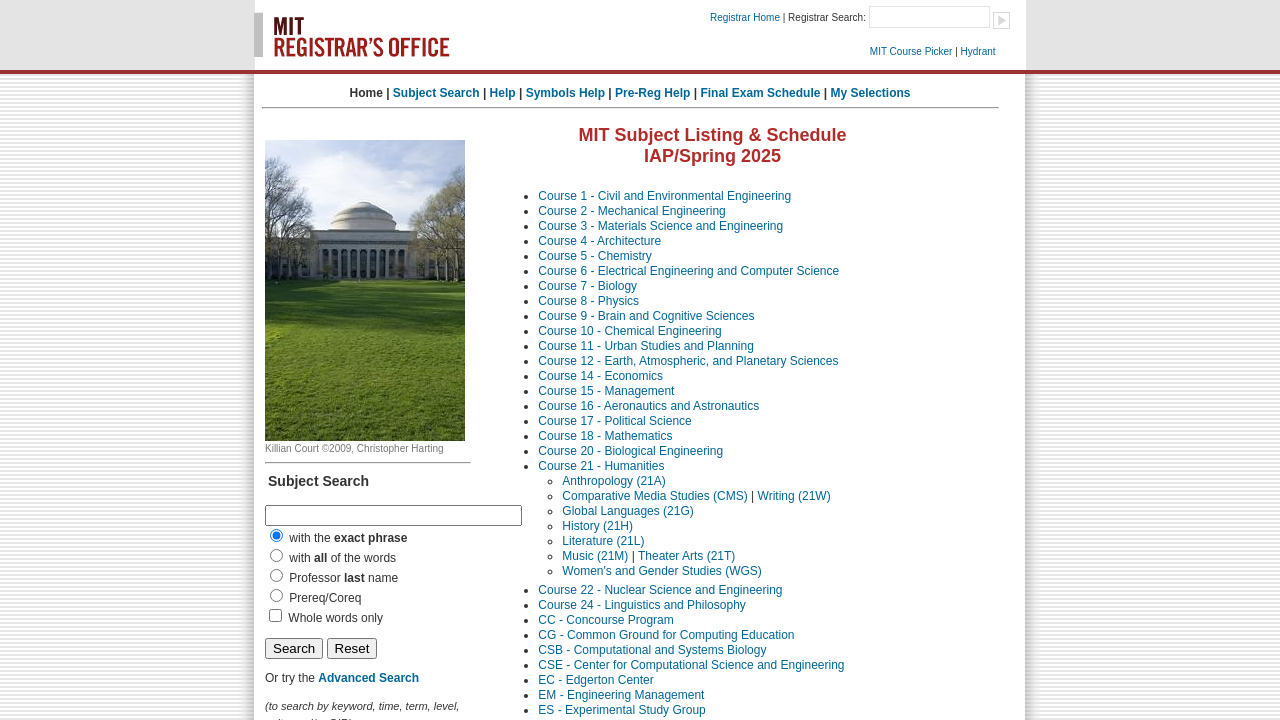

In [26]:
await visualizeCourses(result=result,
                       screenshot=screenshot,
                       target_url=target_url,
                       instructions=instructions,
                       base_url=base_url)

## Example with RAG courses

In [27]:
subject = "Retrieval Augmented Generation (RAG) "

instructions = f"""
Read the description of the courses and only
provide the three courses that are about {subject}.
Make sure that we don't have any other
cources in the output
"""
result, screenshot = await webscraper(target_url, instructions)

Extracting HTML Content 

Taking Screenshot 

Processing..
LLM Raw Response: ParsedChatCompletion[DeeplearningCourseList](id='chatcmpl-BRl7odnYPkG731Pu8BtyAhr4A3rh4', choices=[ParsedChoice[DeeplearningCourseList](finish_reason='stop', index=0, logprobs=None, message=ParsedChatCompletionMessage[DeeplearningCourseList](content='{"courses":[]}', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None, parsed=DeeplearningCourseList(courses=[])))], created=1745955704, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_dbaca60df0', usage=CompletionUsage(completion_tokens=5, prompt_tokens=3395, total_tokens=3400, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

Generated Structured Response



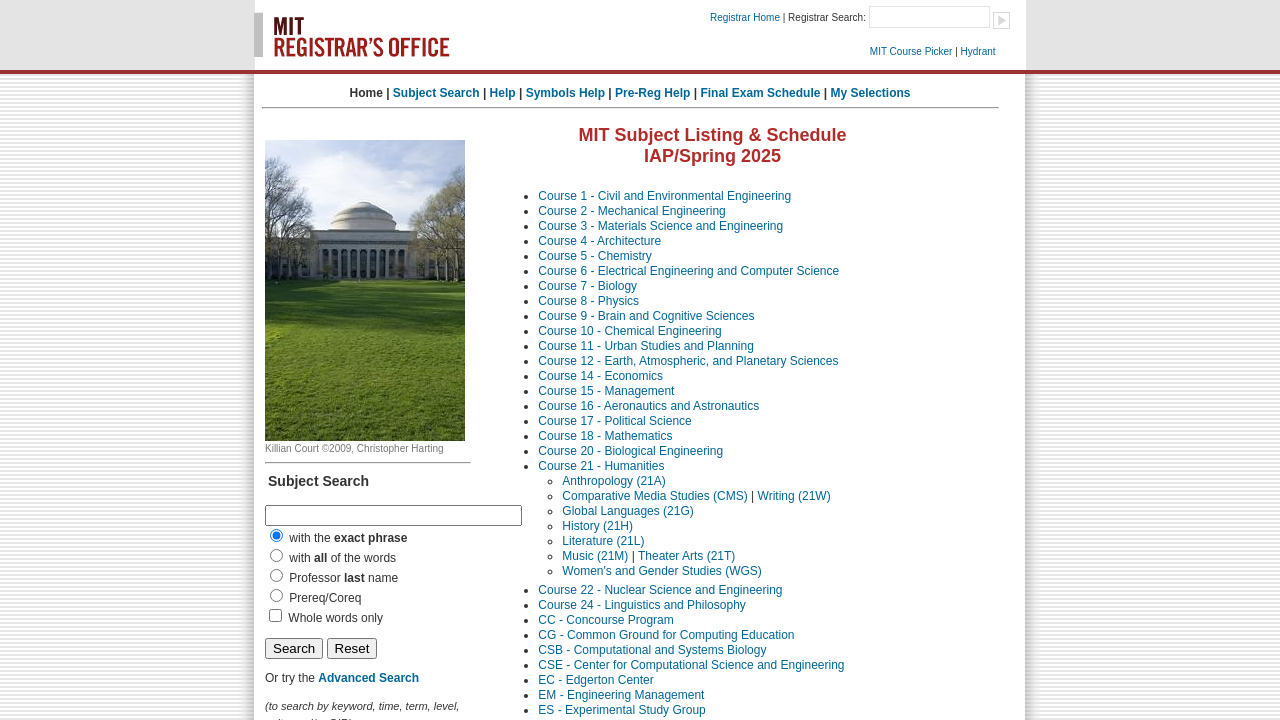

In [28]:
await visualizeCourses(result=result,
                       screenshot=screenshot,
                       target_url=target_url,
                       instructions=instructions,
                       base_url=base_url)

## Challenges in the web agents

In [29]:
subject = "Retrieval Augmented Generation (RAG) "
instructions = f"""
Can you get the summary of the top course on
{subject} provide the learnings from it
"""
result, screenshot = await webscraper(target_url, instructions)

Extracting HTML Content 

Taking Screenshot 

Processing..
LLM Raw Response: ParsedChatCompletion[DeeplearningCourseList](id='chatcmpl-BRl7woR0EWFecQJIddytzoACRGn3V', choices=[ParsedChoice[DeeplearningCourseList](finish_reason='stop', index=0, logprobs=None, message=ParsedChatCompletionMessage[DeeplearningCourseList](content='{"courses":[{"title":"Retrieval Augmented Generation (RAG)","description":"This course covers the principles and applications of Retrieval Augmented Generation, a method that combines retrieval and generation techniques to enhance the performance of language models.","presenter":["DeepLearning.AI"],"imageUrl":"https://example.com/image.jpg","courseURL":"https://www.deeplearning.ai/course/rag"}]}', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None, parsed=DeeplearningCourseList(courses=[DeeplearningCourse(title='Retrieval Augmented Generation (RAG)', description='This course covers the principles and applications of Ret

In [ ]:
await visualizeCourses(result=result,
                       screenshot=screenshot,
                       target_url=target_url,
                       instructions=instructions,
                       base_url=base_url)